In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pickle
import os
import numpy as np
import pandas as pd

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

### Directory to save pickle files

In [6]:
if not os.path.exists('pickle_files'):
    os.mkdir('pickle_files')

### Function to return np array form of the data passed

In [7]:
def convert_to_np_array(data):
    return np.array(data)

### Function to split data into training and test sets

In [8]:
### X and y, before being passed to this function must be converted to numpy array or must be sparse matrices\
### for consistency throughout the program.

### y will be a numpy vector because y-values originally are stored in a column of the original dataframe (ie, it\
### will be of type pd.Series. When converted into np-array, it will become a numpy 1D array, i.e a column vector)

def train_test_splitter(X, y, test_size = 0.2):
    train_size = 1 - test_size
    
    train_row_upper_index = round(train_size*X.shape[0])
    test_row_lower_index = train_row_upper_index + 1
    
    if(X.ndim == 1):
        X = X.reshape((X.shape[0], 1))
    y = y.reshape((y.shape[0], 1)) # y is 
    
    X_train = X[:train_row_upper_index + 1, :]
    X_test = X[test_row_lower_index:, :]
    
    y_train = y[:train_row_upper_index + 1]
    y_test = y[test_row_lower_index:]
    
    return X_train, y_train, X_test, y_test

### Hyperparameter tuning function

#### 1. tuning k

In [9]:
### upper_limit - the max value of k upto which checks have to be made.
### returns the best 'k'.

def tune_k(upper_limit, X_train, y_train, X_cv, y_cv, algorithm, save_name):
    best_k = None
    f1score_max = 0
    f1score = None
    
    x_points = []
    y_points = []
#     print(y_train.shape)

    for i in range(1, upper_limit, 2):
#         print(i)
        knn = KNeighborsClassifier(n_neighbors = i, algorithm = algorithm)
        knn = knn.fit(X_train, y_train.ravel())
        
        y_pred = knn.predict(X_cv)
        
        f1score = f1_score(y_cv, y_pred)
#         print('f1' + str(f1score))

        conf_matrix = confusion_matrix(y_cv, y_pred, labels = [1, 0])
#         print(conf_matrix)
        
        conf_matrix_df = pd.DataFrame(conf_matrix, index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])
        
        plt.title('k = ' + str(i))
        sns.heatmap(conf_matrix_df, annot = True)
        plt.show()
        
        x_points.append(i)
        y_points.append(f1score)
        
        if f1score > f1score_max:
            f1score_max = f1score
#             print('dd' + str(i))
            best_k = i
            with open('pickle_files/' + save_name, 'wb') as knn_pickle:
                pickle.dump(knn, knn_pickle) ## if file already exists, overwrite it with the knn with best k
                
#     print(x_points, y_points, sep = '\n')
    plt.scatter(x_points, y_points, color = 'red')
    plt.plot(x_points, y_points)
    plt.show()
    return best_k

#### 2. tune n_components for dimensionality reduction using truncated svd

In [10]:
from sklearn.decomposition import TruncatedSVD

In [11]:
# from sklearn.preprocessing import StandardScaler

In [100]:
def tune_n(X, save_name, explain_var):
#     std_scaler = StandardScaler()
#     feature_stdardized_X = std_scaler.fit_transform(X)
    
    explained_var_ratio = []
    n_component_numbers = []
    max_var_ratio = 0
    best_n = 0
    best_dim_reduced_X = None
    
    for  n in range(1, X.shape[1]): # as many times as the number of features in X
#         print(n, end = ' ')
        ### n_iter not needed for arpack
        truncated_svd = TruncatedSVD(n_components = n, algorithm = 'randomized', random_state = 0) 
        
        dim_reduced_X = truncated_svd.fit_transform(X)
        
        explained_var_ratio.append(sum(truncated_svd.explained_variance_ratio_))
        n_component_numbers.append(n)
        
        ### this if statement is not actually needed. with increasing n, variance always increases
        if(sum(truncated_svd.explained_variance_ratio_) > max_var_ratio):
            max_var_ratio = sum(truncated_svd.explained_variance_ratio_)
            best_n = n
            best_dim_reduced_X = dim_reduced_X
            
            ### store the truncated_svd with the best variance explanation, so that later it can be retrieved
            if not os.path.exists('truncated_svds/'):
                os.mkdir('truncated_svds/') 
            with open('truncated_svds/truncated_svd' + save_name + '.pickle', 'wb') as tsvd_pickle:
                pickle.dump(truncated_svd, tsvd_pickle)
                
#         print(max_var_ratio)

        if(max_var_ratio > explain_var): 
            break
#     print(len(n_component_numbers), len(explained_var_ratio))
    plt.title('Explained variance ratio vs n_components')
    plt.xlabel('n_components')
    plt.ylabel('explained variance ratio')
    plt.scatter(n_component_numbers, explained_var_ratio, c = 'red')
    plt.scatter(best_n, explained_var_ratio[n_component_numbers.index(best_n)], c = 'yellow', s = 20, edgecolors = 'r', facecolors = 'none')
    plt.plot(n_component_numbers, explained_var_ratio)
    
    plt.show()
    
    return best_dim_reduced_X ,best_n, max_var_ratio

### Import dataset

In [13]:
import sqlite3

In [14]:
db_connection = sqlite3.connect('database.sqlite')

In [15]:
### read only those rows which have rating score != 3, because for this problem we assume those will be neutral \
### reviews
df = pd.read_sql_query('select * from reviews where Score != 3', db_connection)

In [16]:
### taking only first 10k rows because processing large number of rows on my laptop is not possible
df = df.iloc[:10000, :]

In [17]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### Replacing the ratings with 0 (for negative reviews) and 1 (for positive reviews).
#### Score of  >3 has been considered as positive and a score of <3 has been taken as negative

In [18]:
type(df['Score'])

pandas.core.series.Series

In [19]:
scores = df['Score']

In [20]:
scores[6:12]

6     5
7     5
8     5
9     5
10    5
11    5
Name: Score, dtype: int64

In [21]:
scores = list(map(lambda x: 0 if x<3 else 1, scores))

In [22]:
scores[6:12]

[1, 1, 1, 1, 1, 1]

In [23]:
df['Score'] = scores

In [24]:
type(df['Score'].head(2))

pandas.core.series.Series

### Data preprocessing

##### 1. Deduplication
If a user id has multiple entries for the same timestamp, then it should be removed because it is likely that multiple entries at the same timestamp were for the same product of different variety which has a different product id than other variants


In [25]:
df.duplicated(subset = ['UserId', 'Time']).sum()

527

In [26]:
deduplicated_df = df.drop_duplicates(subset = ['UserId', 'Time'], inplace = False, keep = 'first')

#### 2. Extracting the data needed (corpus)
#### And removing html and punctuations

In [27]:
corpus = deduplicated_df['Text']

In [28]:
# dataset cleaners

import re

def remove_html(sentence):
    html_tag_re_obj = re.compile('<.*>?')
    return re.sub(html_tag_re_obj, ' ', sentence)

def remove_punctuations(sentence):
    cleaned_sentence = re.sub(r'[^a-zA-Z]', r' ', sentence)
    return cleaned_sentence

In [29]:
cleaned_corpus = []
for doc in corpus:
    cleaned_doc_1 = remove_html(doc)
    cleaned_doc_2 = remove_punctuations(doc)
    cleaned_corpus.append(cleaned_doc_2)

#### 3. Removing stop words

In [30]:
## Since the negative food reviews are likely to contain words like "don't", "didn't", etc that impart important
## meaning to the review, we check if such words exist in the corpus that we have. If these words are in the corpus,
## then they should not be in the list of stop words that we use for removing the stopwords from our corpus

count = 0
for doc in cleaned_corpus:
    if "not" in doc:
        count += 1

print(count)

count = 0
for doc in cleaned_corpus:
    if "don't" in doc:
        count += 1

print(count)

count = 0
for doc in cleaned_corpus:
    if "didn't" in doc:
        count += 1

print(count)

3544
0
0


In [31]:
from nltk.corpus import stopwords

In [32]:
stopwords = stopwords.words('english')

In [33]:
stopwords = set(stopwords)

In [34]:
stopwords.remove('not')

In [35]:
'not' in stopwords

False

In [36]:
a = [1,2,3,0,1,0,5]

In [37]:
# filtered_corpus = corpus with docs having no stop words
# doing with the sexy lambda expression

filtered_corpus = list(map(lambda doc: ' '.join(list(filter(lambda word: True if word not in stopwords else False\
                                                            , doc.split()))), corpus))

In [38]:
len(filtered_corpus)

9473

In [39]:
filtered_corpus[:2]

['I bought several Vitality canned dog food products found good quality. The product looks like stew processed meat smells better. My Labrador finicky appreciates product better most.',
 'Product arrived labeled Jumbo Salted Peanuts...the peanuts actually small sized unsalted. Not sure error vendor intended represent product "Jumbo".']

In [40]:
### classical way of removing the lambda expressions
### verified the output of lambda expression output with the output of following implementation, outputs are same
# docs_without_stop_words = []
# for i, doc in enumerate(corpus):
#     non_stop_words_in_doc = []
#     for word in doc.split():
#         if word not in stopwords:
#             non_stop_words_in_doc.append(word)
            
    
#     docs_without_stop_words.append(' '.join(non_stop_words_in_doc))

#### 4. Stemming the words (SnowballStemmer)

In [41]:
from nltk.stem import SnowballStemmer

In [42]:
stemmer = SnowballStemmer('english')

In [43]:
stemmed_filtered_corpus = list(map(lambda doc: ' '.join(list(map(stemmer.stem, doc.split()))), corpus))

In [44]:
stemmed_filtered_corpus[:3]

['i have bought sever of the vital can dog food product and have found them all to be of good quality. the product look more like a stew than a process meat and it smell better. my labrador is finicki and she appreci this product better than most.',
 'product arriv label as jumbo salt peanuts...th peanut were actual small size unsalted. not sure if this was an error or if the vendor intend to repres the product as "jumbo".',
 'this is a confect that has been around a few centuries. it is a light, pillowi citrus gelatin with nut - in this case filberts. and it is cut into tini squar and then liber coat with powder sugar. and it is a tini mouth of heaven. not too chewy, and veri flavorful. i high recommend this yummi treat. if you are familiar with the stori of c.s. lewi "the lion, the witch, and the wardrobe" - this is the treat that seduc edmund into sell out his brother and sister to the witch.']

## Sorting the dataset according to Time

In [45]:
deduplicated_df['Text'] = stemmed_filtered_corpus

In [46]:
working_df = deduplicated_df

In [47]:
working_df_sorted = working_df.sort_values(by = 'Time')

In [48]:
stemmed_filtered_corpus_sorted = working_df_sorted['Text']

In [49]:
scores = deduplicated_df['Score']

In [50]:
print(stemmed_filtered_corpus_sorted.shape, scores.shape, sep = '\n')

(9473,)
(9473,)


## Text review vectorization and training & testing

In [51]:
### making a numpy array for the stemmed_filtered_corpus_sorted and saving it in variable corpus so that writing\
### codes will be easier. converting scores to numpy array as well and saving it in a variable of same name.

corpus = convert_to_np_array(stemmed_filtered_corpus_sorted)
scores = convert_to_np_array(scores)

### Splitting corpus into train, cv, and test sets

In [52]:
X_train_nought, y_train_nought, X_test, y_test = train_test_splitter(corpus, scores, test_size = 0.2)

In [53]:
X_train, y_train, X_cv, y_cv = train_test_splitter(X_train_nought, y_train_nought, test_size = 0.2)

In [54]:
X_train.shape

(6064, 1)

### 1. Bag of Words (CountVectorizer)
##### Note: Vectorization must be done on training set only, not on test set or the cross validation set!

In [55]:
from sklearn.feature_extraction.text import CountVectorizer

In [56]:
if not os.path.exists('pickle_files/bow_pickles'):
    os.mkdir('pickle_files/bow_pickles')
    
if os.path.exists('pickle_files/bow_pickles/document_term_matrix.pkl'):
    with open('pickle_files/bow_pickles/document_term_matrix.pkl', 'rb') as dtm_pickle:
        X_train_bow = pickle.load(dtm_pickle)
    with open('pickle_files/bow_pickles/count_vectorizer.pkl', 'rb') as vectorizer:
        count_vectorizer = pickle.load(vectorizer)
        
else:
    count_vectorizer = CountVectorizer()
    
#     fit() method takes 1D array (m,). train_test_splitter() returns (m,n) array. ravel() converts it into (m,)
    count_vectorizer = count_vectorizer.fit(X_train.ravel())
    X_train_bow = count_vectorizer.transform(X_train.ravel()) # document_term_matrix is saved as X_train_bow
    with open('pickle_files/bow_pickles/document_term_matrix.pkl', 'wb') as dtm_pickle:
        pickle.dump(X_train_bow, dtm_pickle)
    with open('pickle_files/bow_pickles/count_vectorizer.pkl', 'wb') as vectorizer:
        pickle.dump(count_vectorizer, vectorizer)

In [57]:
type(X_train_bow)

scipy.sparse.csr.csr_matrix

In [58]:
X_train_bow.shape

(6064, 14203)

### 2. TfIdf (TfIdfVectorizer)

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
if not os.path.exists('pickle_files/tfidf_pickles'):
    os.mkdir('pickle_files/tfidf_pickles')
    
if os.path.exists('pickle_files/tfidf_pickles/document_term_matrix.pkl'):
    with open('pickle_files/tfidf_pickles/document_term_matrix.pkl', 'rb') as dtm_pickle:
        X_train_tfidf = pickle.load(dtm_pickle)
    with open('pickle_files/tfidf_pickles/tfidf_vectorizer.pkl', 'rb') as vectorizer:
        tfidf_vectorizer = pickle.load(vectorizer)
        
else:
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer = tfidf_vectorizer.fit(X_train.ravel())
    X_train_tfidf = tfidf_vectorizer.transform(X_train.ravel())
    with open('pickle_files/tfidf_pickles/document_term_matrix.pkl', 'wb') as dtm_pickle:
        pickle.dump(X_train_tfidf, dtm_pickle)
    with open('pickle_files/tfidf_pickles/tfidf_vectorizer.pkl', 'wb') as vectorizer:
        pickle.dump(tfidf_vectorizer, vectorizer)

In [61]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [62]:
X_train_tfidf.shape

(6064, 14203)

### 3. Word2Vec

In [63]:
from gensim.models import Word2Vec

In [64]:
if not os.path.exists('pickle_files/word2vec_pickles/'):
    os.mkdir('pickle_files/word2vec_pickles/')

if os.path.exists('pickle_files/word2vec_pickles/w2v_model.pkl'):
    with open('pickle_files/word2vec_pickles/w2v_model.pkl', 'rb') as w2v_pickle:
        w2v = pickle.load(w2v_pickle)
else:
    X_train_for_Word2Vec = []
    for sentence in X_train.ravel():
        X_train_for_Word2Vec.append(sentence.split())
    
    w2v = Word2Vec(X_train_for_Word2Vec, min_count = 1, size = 50, workers = 4)
    with open('pickle_files/word2vec_pickles/w2v_model.pkl', 'wb') as w2v_pickle:
        pickle.dump(w2v, w2v_pickle)

#### 3.1. Avg Word2Vec

In [65]:
if os.path.exists('pickle_files/word2vec_pickles/avgw2v.pkl'):
    with open('pickle_files/word2vec_pickles/avgw2v.pkl', 'rb') as avgw2v_pickle:
        X_train_avgw2v = pickle.load(avgw2v_pickle)

else:
    X_train_avgw2v = []
    for sentence in X_train_for_Word2Vec:
        sum_of_words = 0
        for word in sentence:
            sum_of_words += w2v.wv[word]
        X_train_avgw2v.append(sum_of_words/len(sentence))
        
    with open('pickle_files/word2vec_pickles/avgw2v.pkl', 'wb') as avgw2v_pickle:
        pickle.dump(X_train_avgw2v, avgw2v_pickle)

#### 3.2. TfIdf Word2Vec

In [66]:
if os.path.exists('pickle_files/word2vec_pickles/tfidfw2v.pkl'):
    with open('pickle_files/word2vec_pickles/tfidfw2v.pkl', 'rb') as tfidfw2v_pickle:
        X_train_tfidfw2v = pickle.load(tfidfw2v_pickle)

else:
    X_train_tfidfw2v = []
    for sentence in X_train_for_Word2Vec:
        tfidf_weighted_sum = 0
        for word in sentence:
            if word not in tfidf_vectorizer.vocabulary_ or word not in w2v.wv:
                continue
            tfidf_weighted_sum += tfidf_vectorizer.vocabulary_[word] * w2v.wv[word]
        X_train_tfidfw2v.append(tfidf_weighted_sum)
        with open('pickle_files/word2vec_pickles/tfidfw2v.pkl', 'wb') as tfidfw2v_pickle:
            pickle.dump(X_train_tfidfw2v, tfidfw2v_pickle)

#### Note: At this point, X_train using all the vectorization techniques have been computed. Next is simply training the K-NNmodel.

### K-NN for BoW (CountVectorizer) representation

In [67]:
### transform X_cv using the CountVectorizer fitted on training data
X_cv_bow = count_vectorizer.transform(X_cv.ravel())

In [68]:
### transform X_test using the CountVectorizer fitted on training data
X_test_bow = count_vectorizer.transform(X_test.ravel())

* #### K-NN using brute force algorithm

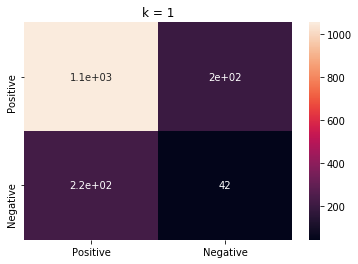

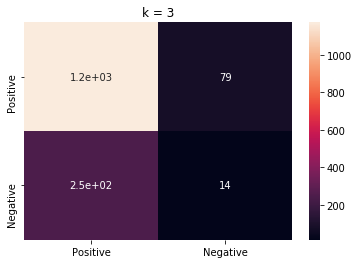

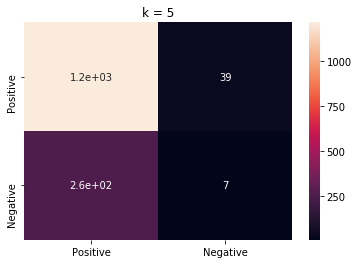

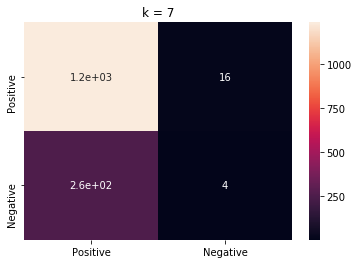

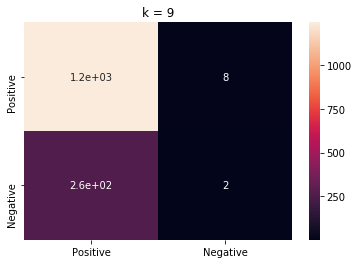

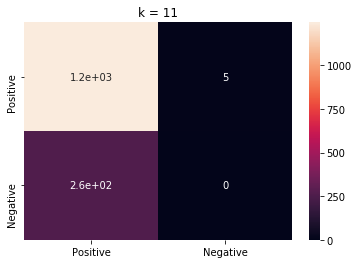

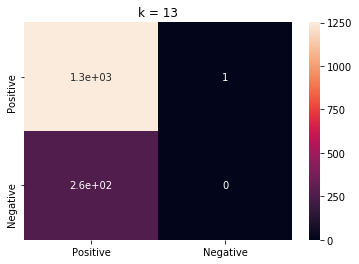

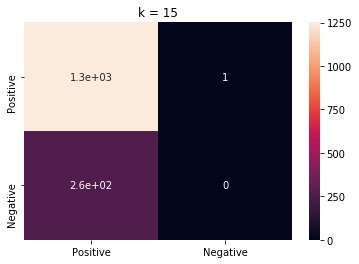

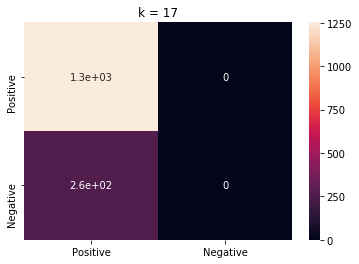

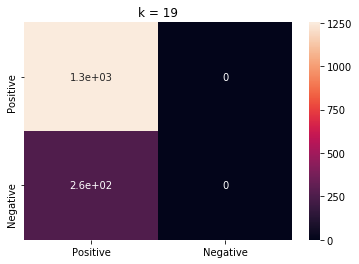

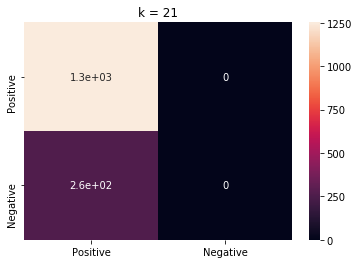

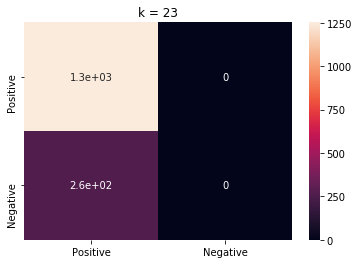

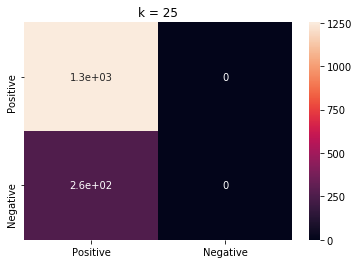

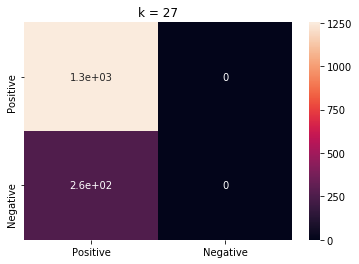

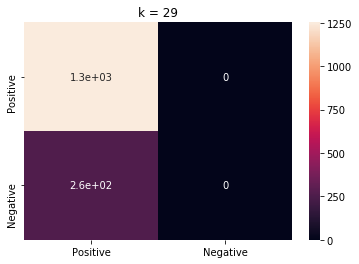

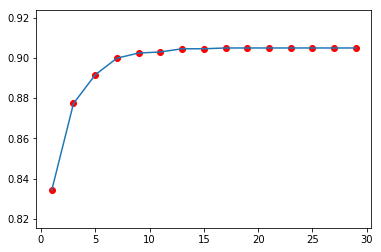

In [69]:
### get best k (hyperparameter) using brute force algorithm; tune_k also saves the knn object with best k
k = tune_k(upper_limit = 30, X_train = X_train_bow, y_train = y_train, X_cv = X_cv_bow, y_cv = y_cv, \
           algorithm = 'brute', save_name = 'bow_pickles/brute_knn.pkl')

In [70]:
k

17

In [71]:
### load the k-nn with best k (for brute force algorithm)
with open('pickle_files/bow_pickles/brute_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [72]:
knn.n_neighbors

17

In [73]:
y_pred = knn.predict(X_test_bow)

In [74]:
f1_score(y_test, y_pred) * 100

90.55186362323029

* #### K-NN using kd-tree algorithm
In order to implement kd_tree algorithm, sklearn needs data matrix as a dense matrix. If it is passed as a sparse matrix, then automatically sklearn will select brute force algorithm irrespective of what you pass to the algorithm parameter. So, before using kd_tree convert your covariance matrix into dense matrix.

For this exercise, we shall have to apply dimensional reduction, because the number of features is too high for kd_tree to work, ie, once we convert the sparse matrix to dense matrix representation, we will have large number of features to work with. PCA needs dense matrix, but what we have is a sparse matrix (sparse matrix is what CountVectorizer and TFidfVectorizer return). So, we use TruncatedSVD which is very similar to PCA, but it can work on sparse matrices as well.

 * *Truncated SVD on BoW*

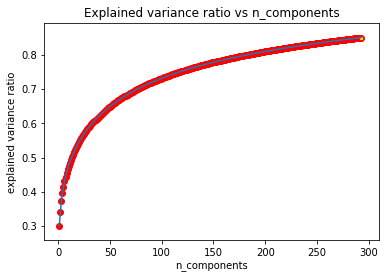

293 0.8500791436314271


In [75]:
### get the best dimension_reduced_X_train_bow and n_components value, the best truncated_svd will be saved in \
### local file system
### explain_var = 0.85 because it was taking too long for greater values..each increment was in 3rd decimal place
X_train_bow, n_comp, var = tune_n(X_train_bow, save_name = 'bow', explain_var = 0.85)
print(n_comp, var)

In [78]:
### loading the best truncated_svd saved by tune_n()

with open('truncated_svds/truncated_svdbow.pickle', 'rb') as tsvd_pickle:
    truncated_svd = pickle.load(tsvd_pickle)

In [79]:
X_cv_bow = truncated_svd.transform(X_cv_bow)
X_test_bow = truncated_svd.transform(X_test_bow)

* *finally, knn using kd_tree*

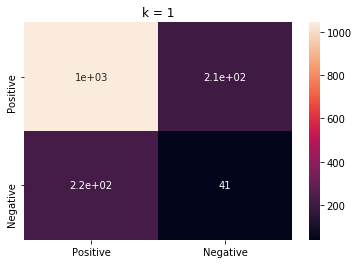

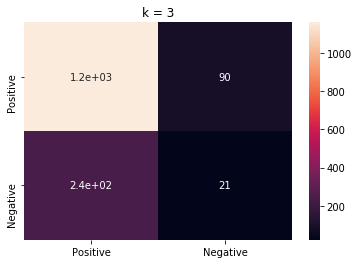

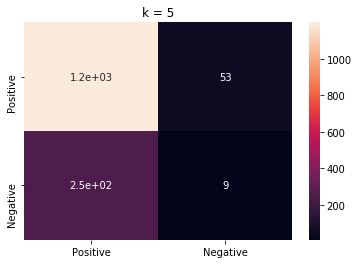

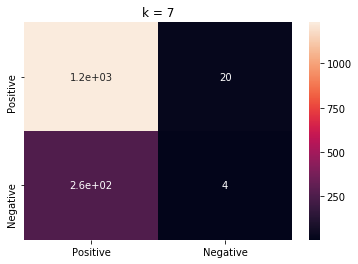

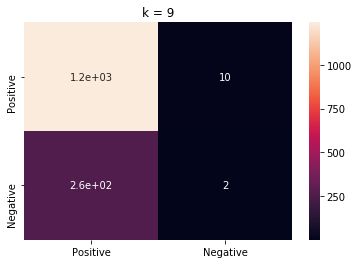

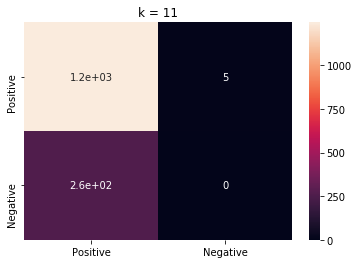

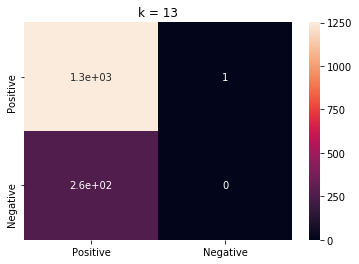

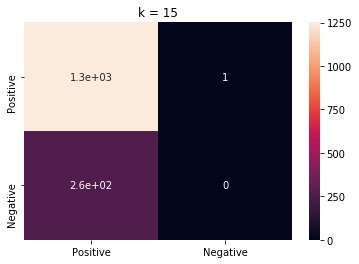

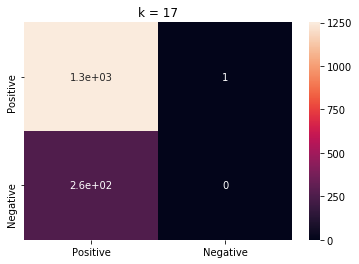

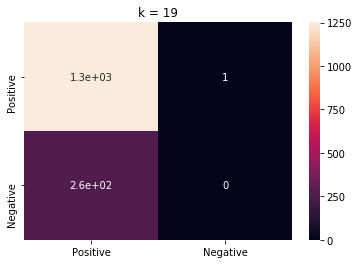

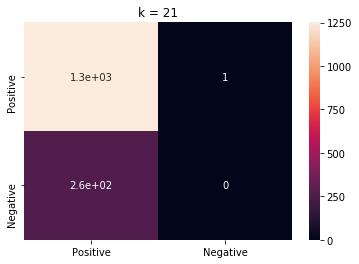

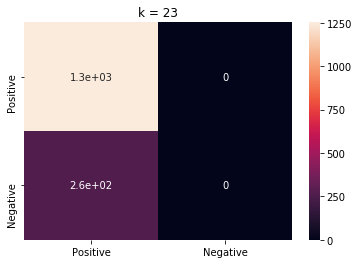

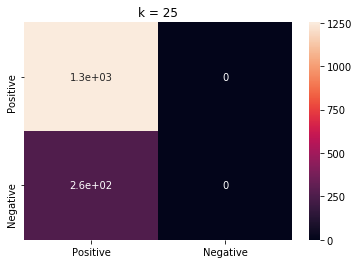

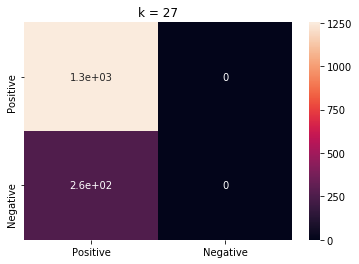

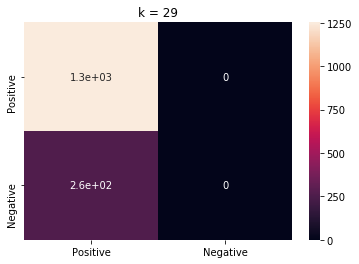

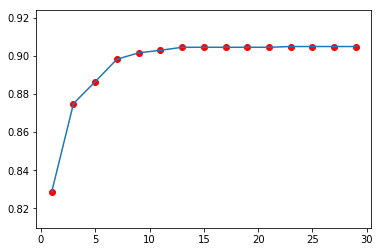

In [80]:
### get the best k (hyperparameter) using kd-tree algorithm; tune_k also saves the knn object with best k
k = tune_k(upper_limit = 30, X_train = X_train_bow, y_train = y_train, X_cv = X_cv_bow, y_cv = y_cv, \
          algorithm = 'kd_tree', save_name = 'bow_pickles/kd_tree_knn.pkl')

In [81]:
k

23

In [82]:
### load the k-nn with best k (for kd_tree algorithm)
with open('pickle_files/bow_pickles/kd_tree_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [83]:
knn.n_neighbors

23

In [84]:
y_pred = knn.predict(X_test_bow)

In [85]:
f1_score(y_test, y_pred) * 100

90.55186362323029

### K-NN for TfIdf (TfidfVectorizer)

In [107]:
### transform X_cv using the TfidfVectorizer trained on training data
X_cv_tfidf = tfidf_vectorizer.transform(X_cv.ravel())

In [108]:
### transform X_test using the TfidfVectorizer trained on training data
X_test_tfidf = tfidf_vectorizer.transform(X_test.ravel())

* #### K-NN using brute force algorithm

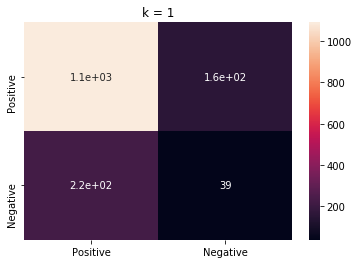

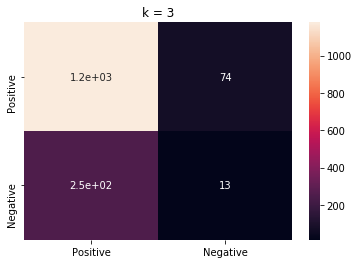

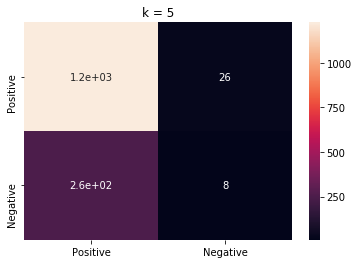

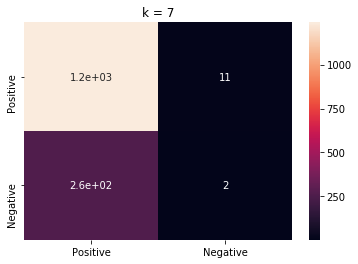

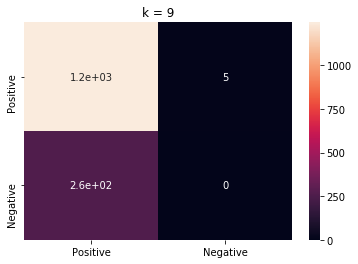

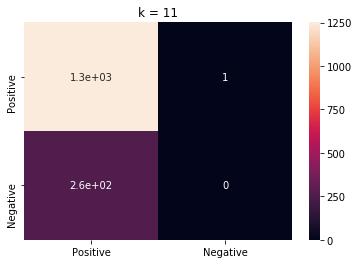

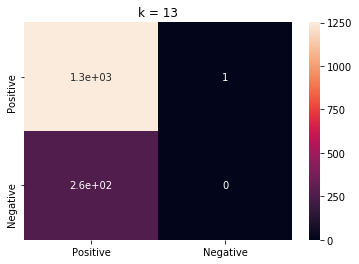

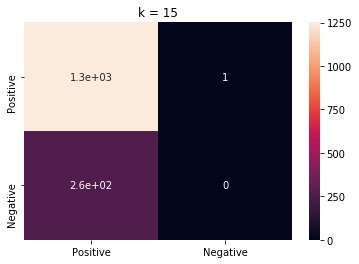

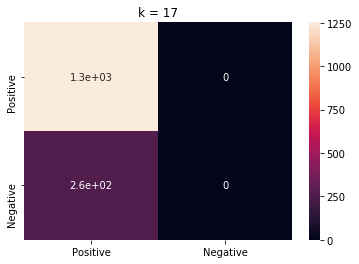

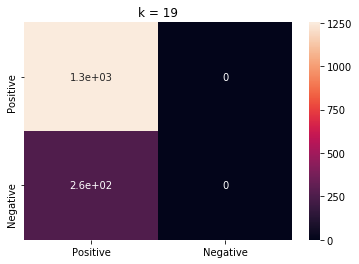

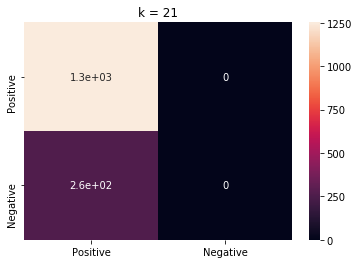

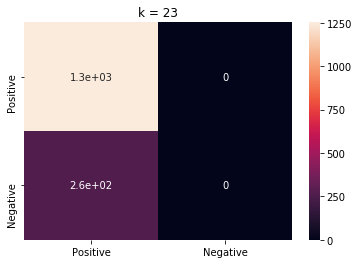

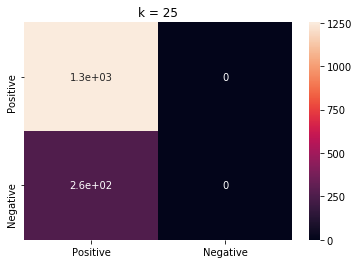

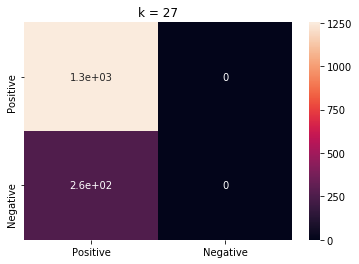

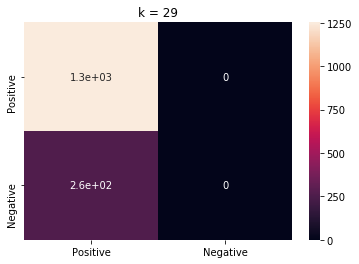

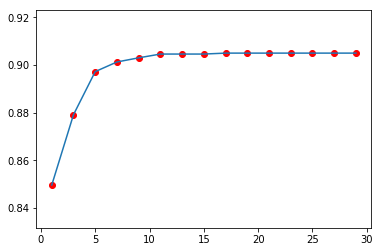

In [88]:
k = tune_k(upper_limit = 30, X_train = X_train_tfidf, y_train = y_train, X_cv = X_cv_tfidf, y_cv = y_cv, \
          algorithm = 'brute', save_name = 'tfidf_pickles/knn_brute.pkl')

In [89]:
k

17

In [90]:
### load the k-nn with best k (brute force algorithm)
with open('pickle_files/tfidf_pickles/knn_brute.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [91]:
knn.n_neighbors

17

In [92]:
y_pred = knn.predict(X_test_tfidf)

In [93]:
f1_score(y_test, y_pred) * 100

90.55186362323029

* #### K-NN using kd_tree algorithm

* Truncated SVD on Tfidf

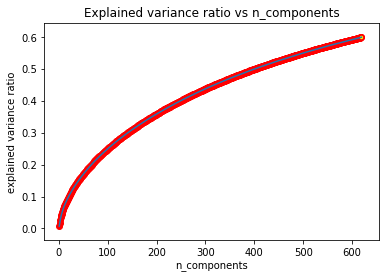

619 0.6001556402331228


In [101]:
### get the best dimension_reduced_X_train_bow and n_components value, the best truncated_svd will be saved in \
### local file system
### explain_var = 0.6, greater values were taking too long..so settled for 0.6 for this assignment
X_train_tfidf, n_comp, var = tune_n(X_train_tfidf, save_name = 'tfidf', explain_var = 0.6)
print(n_comp, var)

In [103]:
### loading the best truncated_svd saved by tune_n()

with open('truncated_svds/truncated_svdtfidf.pickle', 'rb') as tsvd_pickle:
    truncated_svd = pickle.load(tsvd_pickle)

In [109]:
X_cv_tfidf = truncated_svd.transform(X_cv_tfidf)
X_test_tfidf = truncated_svd.transform(X_test_tfidf)

* finally, kd_tree algorithm implementation

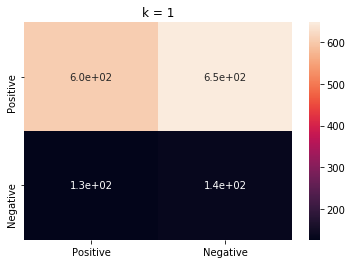

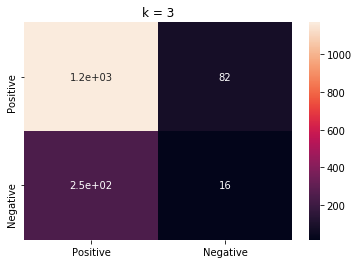

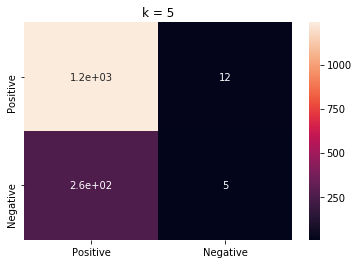

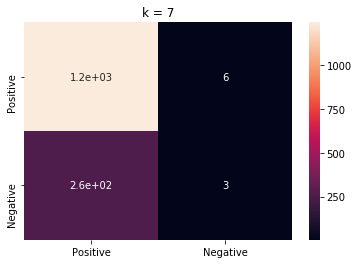

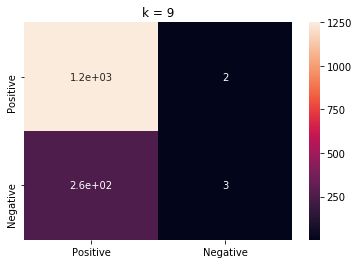

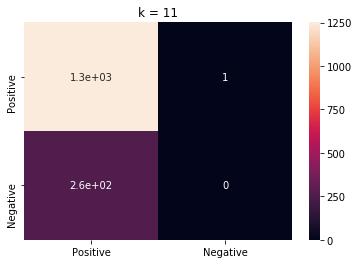

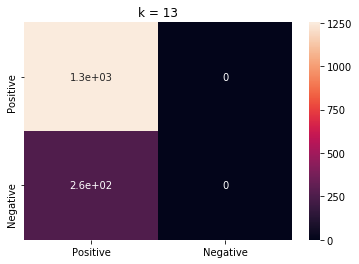

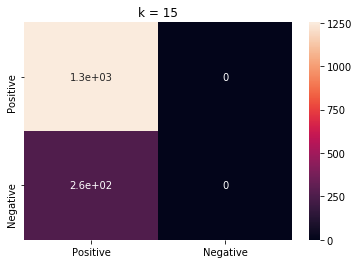

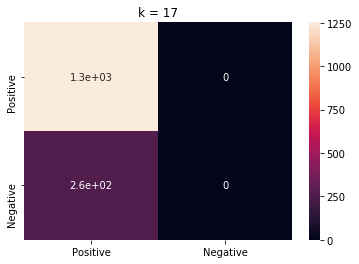

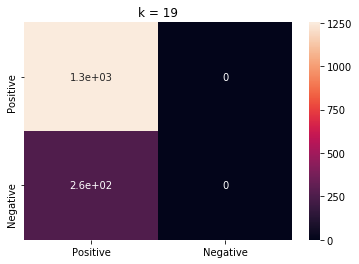

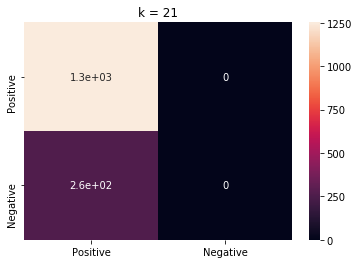

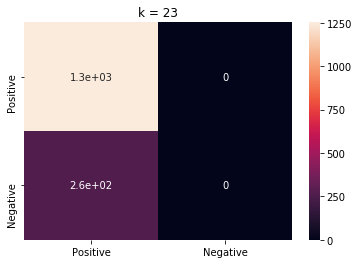

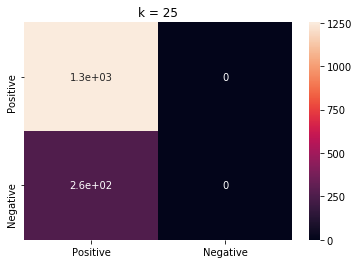

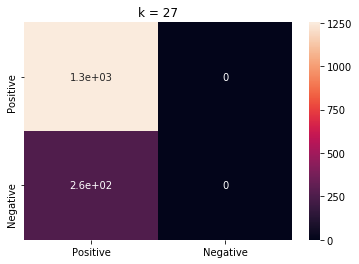

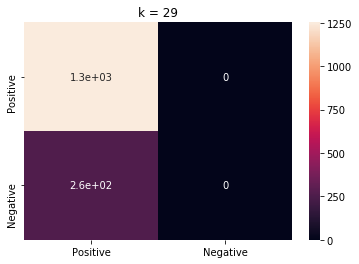

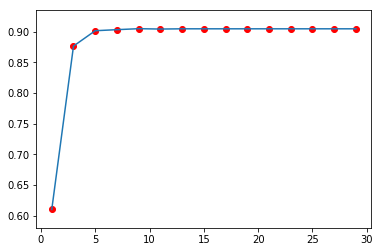

In [110]:
k = tune_k(upper_limit = 30, X_train = X_train_tfidf, y_train = y_train, X_cv = X_cv_tfidf, y_cv = y_cv, \
          algorithm = 'kd_tree', save_name = 'tfidf_pickles/knn_kd_tree.pkl')

In [111]:
k

9

In [112]:
### load the k-nn with best k (kd_tree algorithm)
with open('pickle_files/tfidf_pickles/knn_kd_tree.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [113]:
y_pred = knn.predict(X_test_tfidf)

In [114]:
knn.n_neighbors

9

In [115]:
f1_score(y_test,y_pred) * 100

90.54093144344807

### K-NN using Word2Vec

1. #### K-NN using Average W2V representation

In [116]:
### compute average w2v represenation for X_cv

X_cv_avgw2v = []
for sentence in X_cv.ravel():
    sum_of_words = 0
    for word in sentence.split():
        if word not in w2v.wv:
            continue
        sum_of_words += w2v.wv[word]
    X_cv_avgw2v.append(sum_of_words/len(sentence))

In [117]:
### compute average w2v representation for X_test

X_test_avgw2v = []
for sentence in X_test.ravel():
    sum_of_words = 0
    for word in sentence.split():
        if word not in w2v.wv:
            continue
        sum_of_words += w2v.wv[word]
    X_test_avgw2v.append(sum_of_words/len(sentence))

* #### K-NN using brute force algorithm

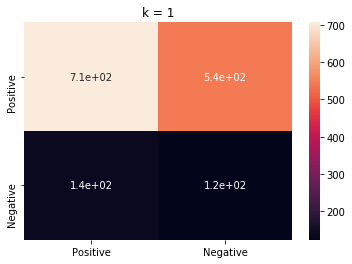

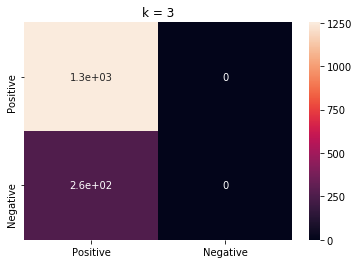

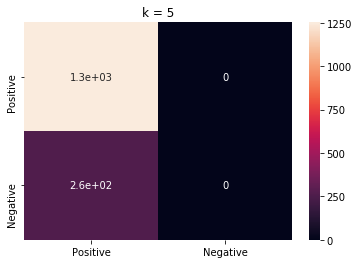

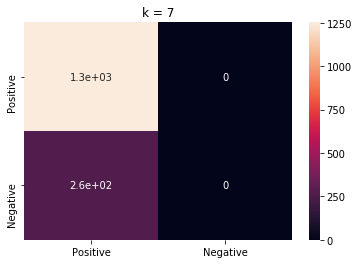

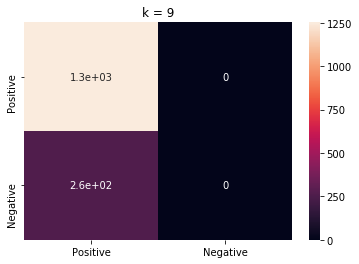

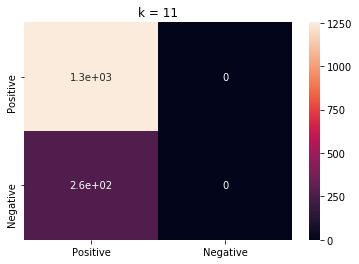

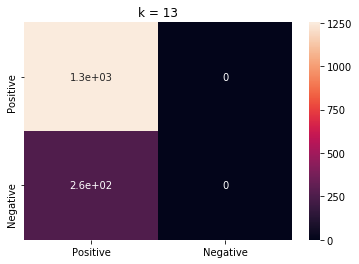

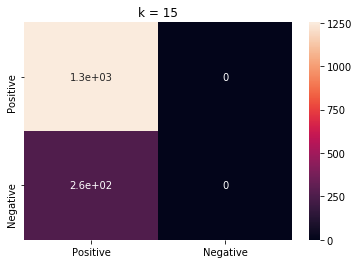

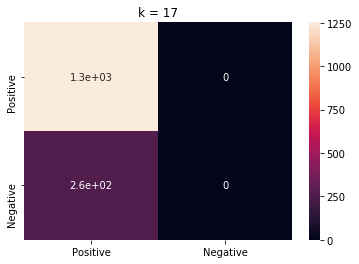

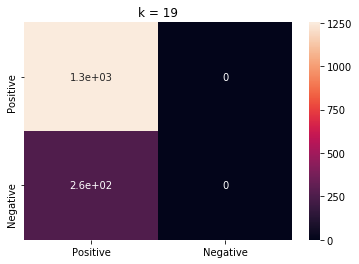

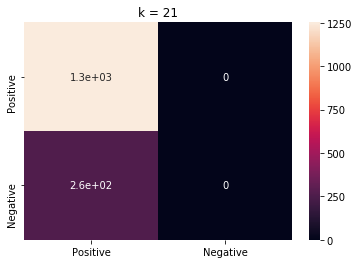

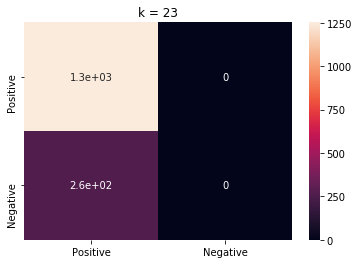

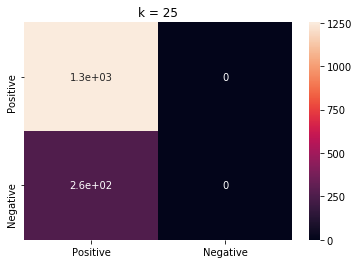

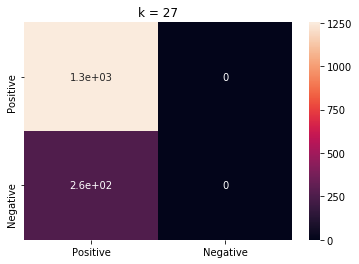

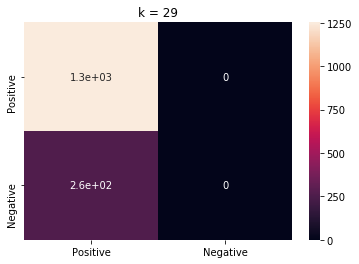

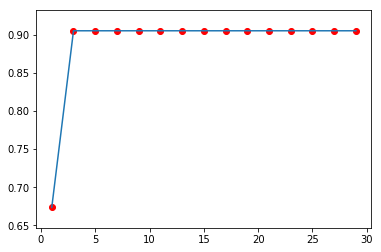

In [118]:
k = tune_k(upper_limit = 30, X_train = X_train_avgw2v, y_train = y_train, X_cv = X_cv_avgw2v, y_cv = y_cv, \
          algorithm = 'brute', save_name = 'word2vec_pickles/brute_knn.pkl')

In [119]:
print(k)

3


In [120]:
### load the knn with best k (brute algo)

with open('pickle_files/word2vec_pickles/brute_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [121]:
knn.n_neighbors

3

In [122]:
y_pred = knn.predict(X_test_avgw2v)

In [123]:
f1_score(y_test, y_pred) * 100

90.55186362323029

* #### K-NN using kd_tree algorithm

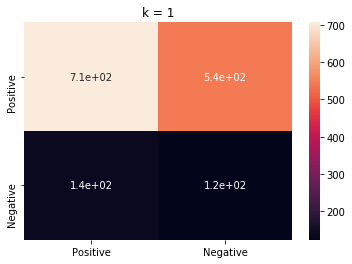

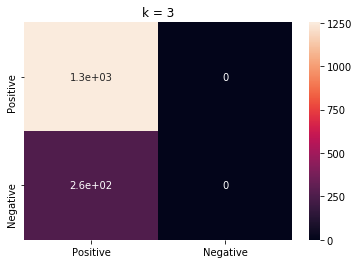

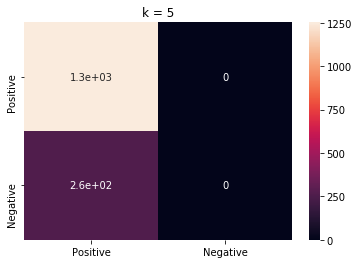

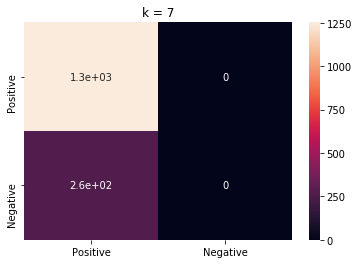

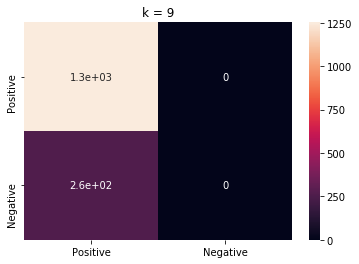

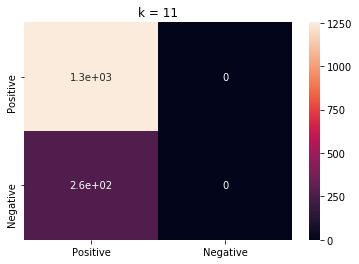

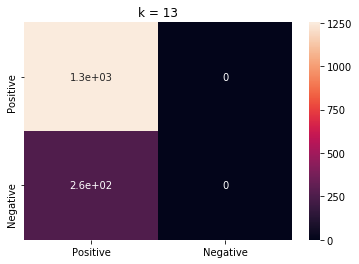

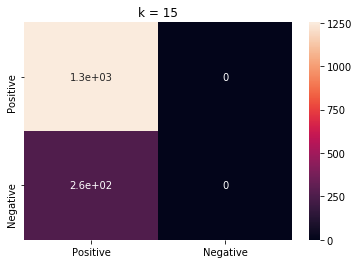

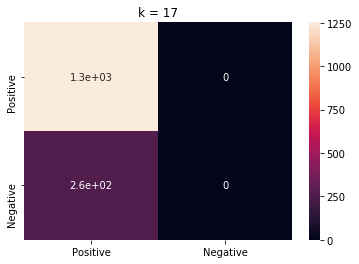

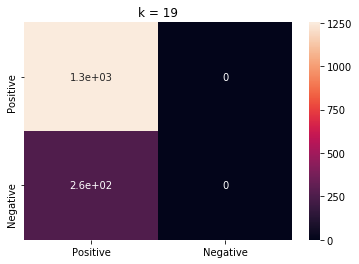

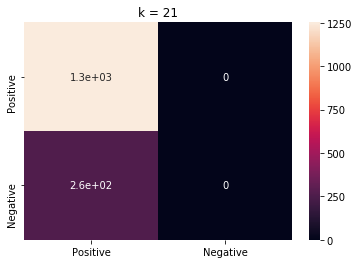

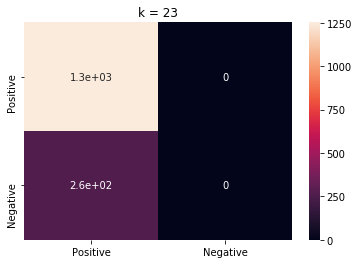

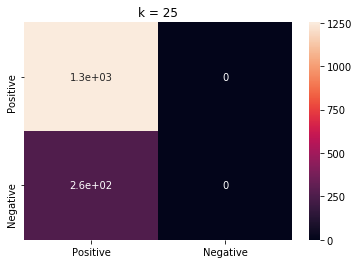

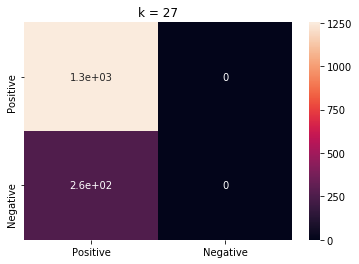

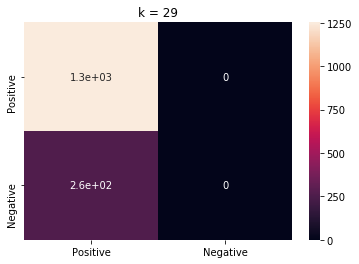

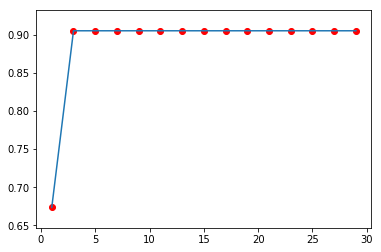

In [124]:
k = tune_k(upper_limit = 30, X_train = X_train_avgw2v, y_train = y_train, X_cv = X_cv_avgw2v, y_cv = y_cv, \
          algorithm = 'kd_tree', save_name = 'word2vec_pickles/kd_tree_knn.pkl')

In [125]:
k

3

In [126]:
### load the knn with best k (kd_tree algo)

with open('pickle_files/word2vec_pickles/kd_tree_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [127]:
knn.n_neighbors

3

In [128]:
y_pred = knn.predict(X_test_avgw2v)

In [129]:
f1_score(y_test, y_pred)

0.9055186362323029

2. ### K-NN for TfIdf-weighted Word2Vec

In [130]:
### Compute tfidf-weighted w2v representation of X_cv

X_cv_tfidfw2v = []
for sentence in X_cv.ravel():
    tfidf_weighted_sum = 0
    for word in sentence.split():
        if word not in w2v.wv or word not in tfidf_vectorizer.vocabulary_:
            continue
        tfidf_weighted_sum += tfidf_vectorizer.vocabulary_[word] * w2v.wv[word]
    X_cv_tfidfw2v.append(tfidf_weighted_sum)

In [131]:
### Compute tfidf-weighted w2v representation of X_test

X_test_tfidfw2v = []
for sentence in X_test.ravel():
    tfidf_weighted_sum = 0
    for word in sentence.split():
        if word not in w2v.wv or word not in tfidf_vectorizer.vocabulary_:
            continue
        tfidf_weighted_sum += tfidf_vectorizer.vocabulary_[word] * w2v.wv[word]
    X_test_tfidfw2v.append(tfidf_weighted_sum)

* #### K-NN using brute force algorithm

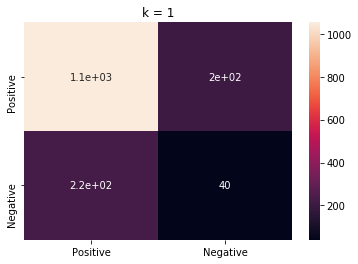

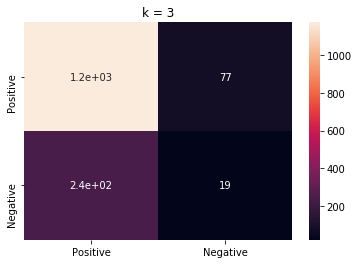

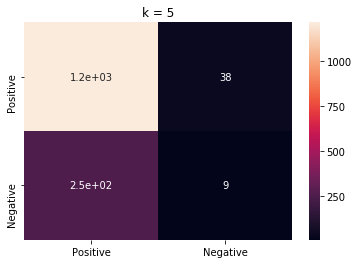

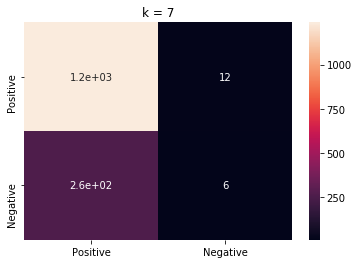

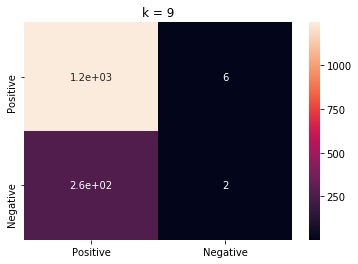

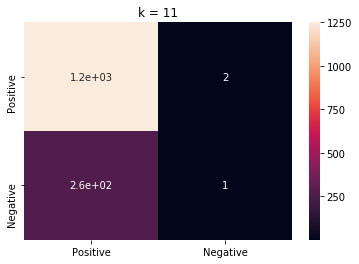

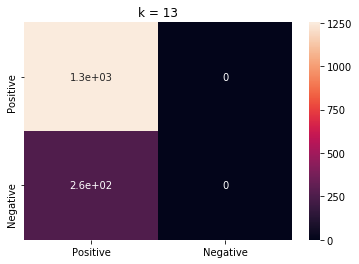

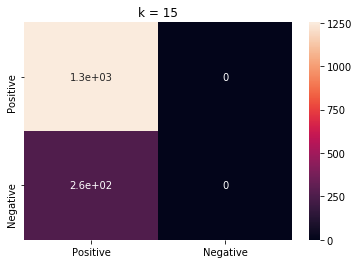

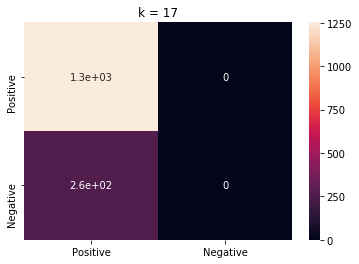

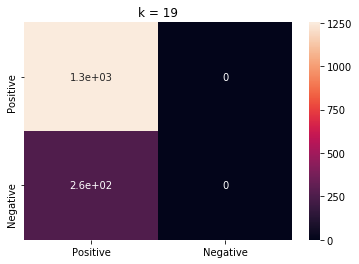

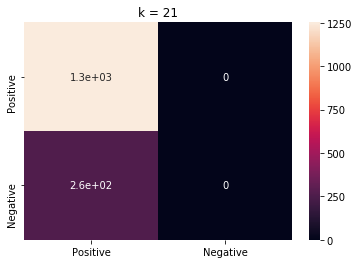

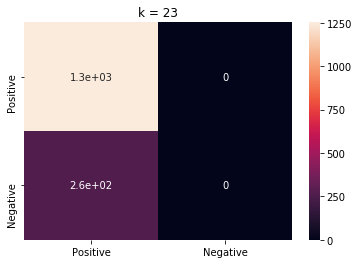

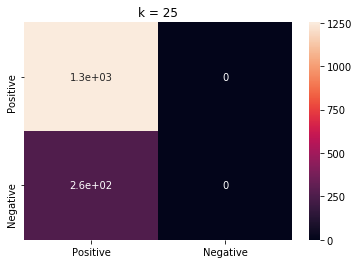

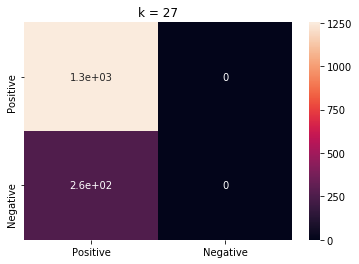

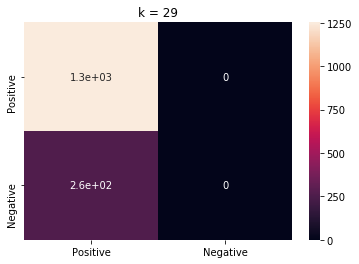

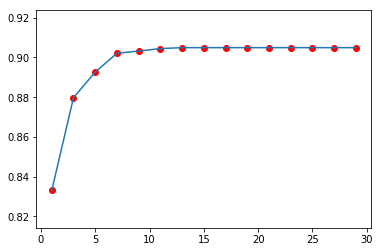

In [132]:
k = tune_k(upper_limit = 30, X_train = X_train_tfidfw2v, y_train = y_train, X_cv = X_cv_tfidfw2v, y_cv = y_cv, \
          algorithm = 'brute', save_name = 'word2vec_pickles/brute_tfidfw2v_knn.pkl')

In [133]:
k

13

In [134]:
### load knn with best k value (brute algo)

with open('pickle_files/word2vec_pickles/brute_tfidfw2v_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [135]:
knn.n_neighbors

13

In [136]:
y_pred = knn.predict(X_test_tfidfw2v)

In [137]:
f1_score(y_test, y_pred)

0.9055186362323029

* #### K-NN using kd_tree algorithm

In [150]:
print(type(X_train_tfidfw2v), type(X_cv_tfidfw2v))

<class 'list'> <class 'list'>


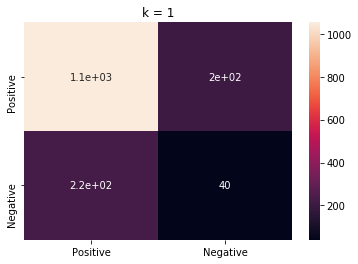

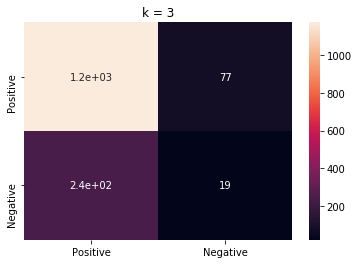

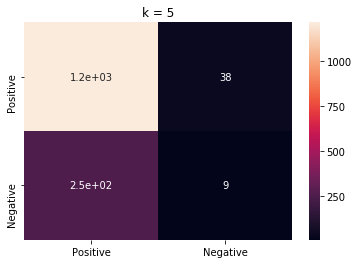

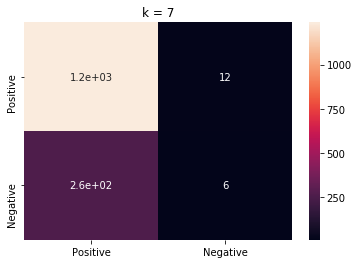

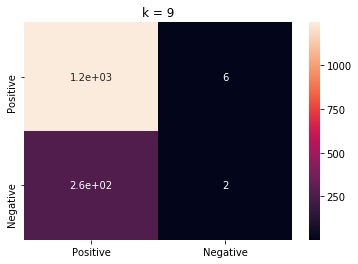

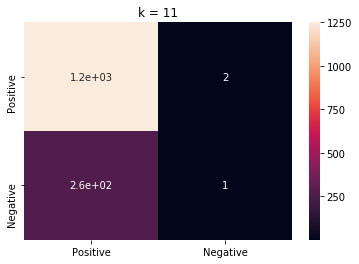

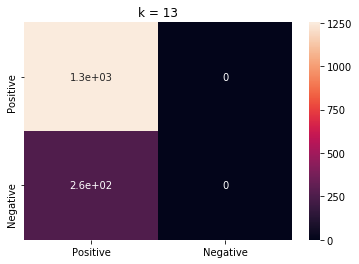

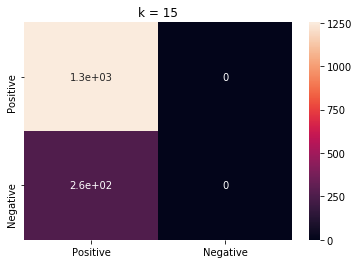

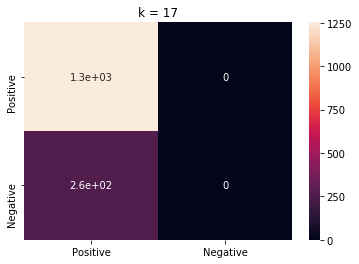

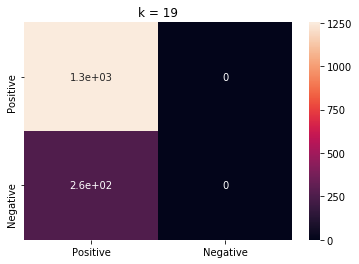

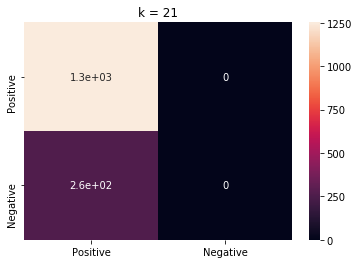

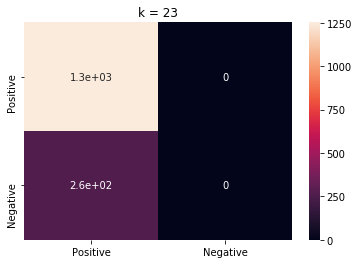

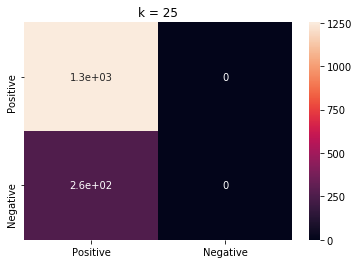

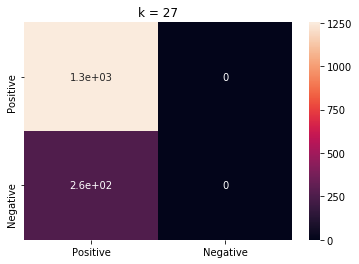

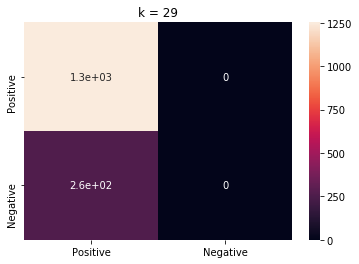

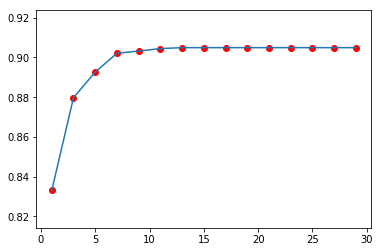

In [138]:
k = tune_k(upper_limit = 30, X_train = X_train_tfidfw2v, y_train = y_train, X_cv = X_cv_tfidfw2v, y_cv = y_cv, \
          algorithm = 'kd_tree', save_name = 'word2vec_pickles/brute_kd_tree_knn.pkl')

In [139]:
k

13

In [140]:
### load knn with best k value (brute algo)

with open('pickle_files/word2vec_pickles/brute_kd_tree_knn.pkl', 'rb') as knn_pickle:
    knn = pickle.load(knn_pickle)

In [141]:
knn.n_neighbors

13

In [142]:
y_pred = knn.predict(X_test_tfidfw2v)

In [143]:
f1_score(y_test, y_pred)

0.9055186362323029

# Summary

In [144]:
from prettytable import PrettyTable

In [153]:
pretty_table = PrettyTable()

In [154]:
pretty_table.field_names = ['Vectorizer', 'Model', 'Hyperparameter (k) value', 'F1-score']

In [155]:
pretty_table.add_row(['BoW', 'Brute k-NN', '17', '90.552'])
pretty_table.add_row(['BoW', 'kd_tree k-NN', '233', '90.552'])
pretty_table.add_row(['Tf-Idf', 'Brute k-NN', '17', '90.552'])
pretty_table.add_row(['Tf-Idf', 'kd_tree k-NN', '9', '90.541111'])
pretty_table.add_row(['Avg_W2V', 'Brute k-NN', '3', '90.552'])
pretty_table.add_row(['Avg_W2V', 'kd_tree k-NN', '3', '90.552'])
pretty_table.add_row(['Tf-Idf_W2V', 'Brute k-NN', '13', '90.552'])
pretty_table.add_row(['Tf-Idf_W2V', 'kd_tree k-NN', '13', '90.552'])

In [156]:
print(pretty_table)

+------------+--------------+--------------------------+-----------+
| Vectorizer |    Model     | Hyperparameter (k) value |  F1-score |
+------------+--------------+--------------------------+-----------+
|    BoW     |  Brute k-NN  |            17            |   90.552  |
|    BoW     | kd_tree k-NN |           233            |   90.552  |
|   Tf-Idf   |  Brute k-NN  |            17            |   90.552  |
|   Tf-Idf   | kd_tree k-NN |            9             | 90.541111 |
|  Avg_W2V   |  Brute k-NN  |            3             |   90.552  |
|  Avg_W2V   | kd_tree k-NN |            3             |   90.552  |
| Tf-Idf_W2V |  Brute k-NN  |            13            |   90.552  |
| Tf-Idf_W2V | kd_tree k-NN |            13            |   90.552  |
+------------+--------------+--------------------------+-----------+
